In [1]:
import modin.pandas as pd
import numpy as np

import pickle

from sklearn.preprocessing import QuantileTransformer

import seaborn as sns

In [2]:
training_dat = pd.read_pickle('./PROCESSED/training_dat.pkl')
training_dat.head()

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

To request implementation, send an email to feature_requests@modin.org.


,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,...,Original Loan Term,Number of Borrowers,Seller Name,Servicer Name,Super Conforming Flag,Pre-HARP Loan Sequence Number,Program Indicator,HARP Indicator,Property Valuation Method,Interest Only (I/O) Indicator
0,F110Q1000008,False,804,201004,N,204003,17860.0,0,1,P,...,360,2,Other sellers,U.S. BANK N.A.,NaN,NaN,9,NaN,9,NaN
1,F110Q1000064,False,816,201003,N,204002,44220.0,0,1,P,...,360,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,NaN
2,F110Q1000072,False,783,201003,N,204002,45820.0,0,1,P,...,360,2,Other sellers,U.S. BANK N.A.,NaN,NaN,9,NaN,9,NaN
3,F110Q1000080,False,667,201003,N,204002,17900.0,0,1,P,...,360,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,NaN
4,F110Q1000096,False,799,201003,N,204002,NaN,0,1,P,...,360,1,Other sellers,U.S. BANK N.A.,NaN,NaN,9,NaN,9,NaN


In [3]:
training_dat.dtypes

Loan Sequence Number                                             object
Loan Deliquency Within Year                                        bool
Credit Score                                                      int64
First Payment Date                                                int64
First Time Homebuyer Flag                                        object
Maturity Date                                                     int64
Metropolitan Statistical Area (MSA) Or Metropolitan Division    float64
Mortgage Insurance Percentage (MI %)                              int64
Number of Units                                                   int64
Occupancy Status                                                 object
Original Combined Loan-to-Value (CLTV)                            int64
Original Debt-to-Income (DTI) Ratio                               int64
Original UPB                                                      int64
Original Loan-to-Value (LTV)                                    

In [4]:
# Get rid of HARP record
training_dat = training_dat[training_dat['HARP Indicator']!='Y'].copy()

In [5]:
# The improved training dataset dataframe. Starting with initial columns, and then adding predictors
training_dat2 = training_dat[['Loan Sequence Number','Loan Deliquency Within Year']].copy()
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year
0,F110Q1000008,False
1,F110Q1000064,False
2,F110Q1000072,False
3,F110Q1000080,False
4,F110Q1000096,False


In [6]:
# Storing scalers
scaler_dct = {}

In [7]:
# Cleaning Credit Score
training_dat['Credit Score'].describe()

count    396337.000000
mean        755.107507
std          81.524064
min         508.000000
25%         725.000000
50%         764.000000
75%         790.000000
max        9999.000000
Name: Credit Score, dtype: float64

In [8]:
tf = training_dat['Credit Score'] == 9999
training_dat.loc[tf, 'Credit Score'] = np.nan
training_dat['Credit Score'].describe()

count    396315.000000
mean        754.594366
std          43.621586
min         508.000000
25%         725.000000
50%         764.000000
75%         790.000000
max         850.000000
Name: Credit Score, dtype: float64

In [9]:
scaler_0_1_creditscore = QuantileTransformer(output_distribution='normal')
training_dat2['Credit Score'] = scaler_0_1_creditscore.fit_transform(training_dat[['Credit Score']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score
0,F110Q1000008,False,1.315958
1,F110Q1000064,False,2.225823
2,F110Q1000072,False,0.451469
3,F110Q1000080,False,-1.733071
4,F110Q1000096,False,1.033647


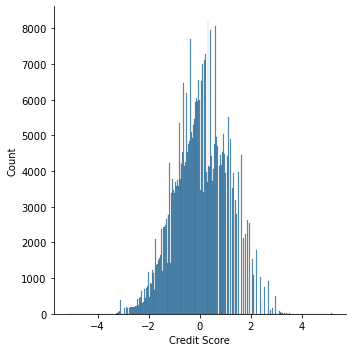

In [10]:
sns.displot(x='Credit Score',data=training_dat2)

In [11]:
training_dat['Credit Score'].head()

0    804
1    816
2    783
3    667
4    799
Name: Credit Score, dtype: int64

In [12]:
scaler_dct['Credit Score'] = scaler_0_1_creditscore

In [13]:
# Cleaning First Time Homebuyer Flag
training_dat['First Time Homebuyer Flag'].value_counts()

9    215276
N    117864
Y     63197
Name: First Time Homebuyer Flag, dtype: int64

In [14]:
training_dat2['First Time Homebuyer Flag'] = np.nan
tf1 = training_dat['First Time Homebuyer Flag'] == 'Y'
training_dat2.loc[tf1, 'First Time Homebuyer Flag'] = True
tf2 = training_dat['First Time Homebuyer Flag'] == 'N'
training_dat2.loc[tf2, 'First Time Homebuyer Flag'] = False
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag
0,F110Q1000008,False,1.315958,False
1,F110Q1000064,False,2.225823,False
2,F110Q1000072,False,0.451469,False
3,F110Q1000080,False,-1.733071,False
4,F110Q1000096,False,1.033647,False


In [15]:
training_dat2['First Time Homebuyer Flag'].unique()

array([False, True, nan], dtype=object)

In [16]:
training_dat[training_dat['First Time Homebuyer Flag']=='Y'][['Loan Sequence Number','First Time Homebuyer Flag']].head()

,Loan Sequence Number,First Time Homebuyer Flag
7,F110Q1000168,Y
18,F110Q1000443,Y
37,F110Q1000922,Y
38,F110Q1000963,Y
43,F110Q1001060,Y


In [17]:
training_dat2[training_dat2['First Time Homebuyer Flag']==True].head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag
7,F110Q1000168,False,-0.465405,True
18,F110Q1000443,False,0.396560,True
37,F110Q1000922,False,1.959536,True
38,F110Q1000963,False,-1.895259,True
43,F110Q1001060,False,0.670557,True


In [18]:
# Cleaning Mortgage Insurance Percentage (MI %)
training_dat['Mortgage Insurance Percentage (MI %)'].describe()

count    396337.000000
mean          5.540459
std          10.918153
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: Mortgage Insurance Percentage (MI %), dtype: float64

<AxesSubplot:xlabel='Mortgage Insurance Percentage (MI %)', ylabel='Density'>

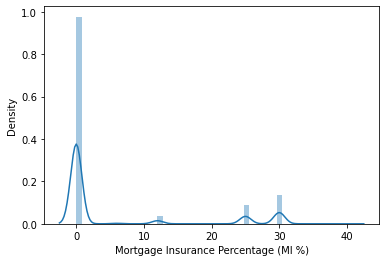

In [19]:
sns.distplot(training_dat['Mortgage Insurance Percentage (MI %)'])

In [20]:
training_dat['Mortgage Insurance Percentage (MI %)'].unique()

array([ 0, 30, 25, 12, 17, 20,  6, 35, 14, 18, 16, 13, 15, 36, 40,  7, 37,
       27, 22, 32, 26], dtype=int64)

In [21]:
# scaler_0_1_mortpct = QuantileTransformer(output_distribution='normal')
# training_dat2['Mortgage Insurance Percentage (MI %)'] = scaler_0_1_mortpct.fit_transform(training_dat[['Mortgage Insurance Percentage (MI %)']])
# training_dat2.head()

In [26]:
# scaler_dct['Mortgage Insurance Percentage (MI %)'] = scaler_0_1_mortpct

In [28]:
training_dat2['MortgageInsuranceFlag'] = 1

tf = training_dat['Mortgage Insurance Percentage (MI %)'] == 0
training_dat2.loc[tf, 'MortgageInsuranceFlag'] = 0

In [29]:
# Transform Number of Units
training_dat['Number of Units'].unique()

array([1, 4, 2, 3], dtype=int64)

<AxesSubplot:xlabel='Number of Units', ylabel='Density'>

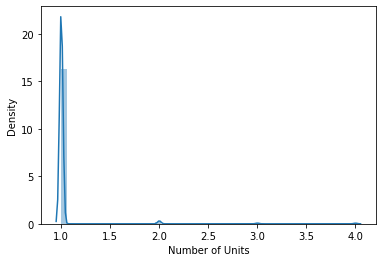

In [30]:
sns.distplot(training_dat['Number of Units'])

In [31]:
dum_df = pd.get_dummies(training_dat['Number of Units'],prefix='Units')
for col in list(dum_df.columns):
    training_dat2[col] = dum_df[col]
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4
0,F110Q1000008,False,1.315958,False,0,1,0,0,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0
2,F110Q1000072,False,0.451469,False,0,1,0,0,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0
4,F110Q1000096,False,1.033647,False,0,1,0,0,0


In [32]:
# Clean/Transform Occupancy Status
training_dat['Occupancy Status'].unique()

array(['P', 'I', 'S'], dtype=object)

In [33]:
training_dat['Occupancy Status'].value_counts()

P    351163
I     28686
S     16488
Name: Occupancy Status, dtype: int64

In [34]:
dum_df = pd.get_dummies(training_dat['Occupancy Status'],prefix='OccupancyStatus')
for col in list(dum_df.columns):
    training_dat2[col] = dum_df[col]
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0


In [35]:
# Clean Original Combined Loan-to-Value (CLTV)
training_dat['Original Combined Loan-to-Value (CLTV)'].describe()

count    396337.000000
mean         72.872349
std          17.604025
min           6.000000
25%          64.000000
50%          78.000000
75%          80.000000
max         999.000000
Name: Original Combined Loan-to-Value (CLTV), dtype: float64

In [36]:
tf = training_dat['Original Combined Loan-to-Value (CLTV)'] == 999
training_dat.loc[tf, 'Original Combined Loan-to-Value (CLTV)'] = np.nan

<AxesSubplot:xlabel='Original Combined Loan-to-Value (CLTV)', ylabel='Density'>

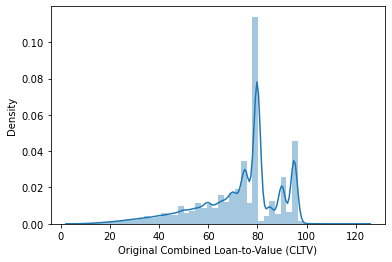

In [37]:
sns.distplot(training_dat['Original Combined Loan-to-Value (CLTV)'])

In [42]:
scaler_0_1_cltv = QuantileTransformer(output_distribution='normal')
training_dat2['Original Combined Loan-to-Value (CLTV)'] = scaler_0_1_cltv.fit_transform(training_dat[['Original Combined Loan-to-Value (CLTV)']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV)
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486


In [43]:
scaler_dct['Original Combined Loan-to-Value (CLTV)'] = scaler_0_1_cltv

<AxesSubplot:xlabel='Original Combined Loan-to-Value (CLTV)', ylabel='Density'>

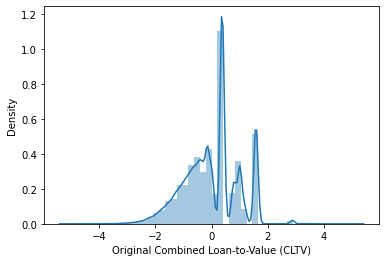

In [44]:
sns.distplot(training_dat2['Original Combined Loan-to-Value (CLTV)'])

In [45]:
# Clean Original Debt-to-Income (DTI) Ratio
training_dat['Original Debt-to-Income (DTI) Ratio'].describe()

count    396337.000000
mean         33.481499
std          13.532473
min           1.000000
25%          26.000000
50%          34.000000
75%          41.000000
max         999.000000
Name: Original Debt-to-Income (DTI) Ratio, dtype: float64

In [46]:
tf = training_dat['Original Debt-to-Income (DTI) Ratio'] == 999
training_dat.loc[tf, 'Original Debt-to-Income (DTI) Ratio'] = np.nan

<AxesSubplot:xlabel='Original Debt-to-Income (DTI) Ratio', ylabel='Density'>

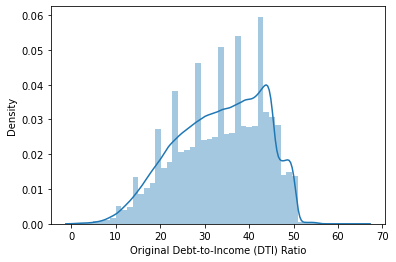

In [47]:
sns.distplot(training_dat['Original Debt-to-Income (DTI) Ratio'])

In [48]:
scaler_0_1_dti = QuantileTransformer(output_distribution='normal')
training_dat2['Original Debt-to-Income (DTI) Ratio'] = scaler_0_1_dti.fit_transform(training_dat[['Original Debt-to-Income (DTI) Ratio']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755,-1.252988
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511,-0.599937
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283,0.139710
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283,-1.252988
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486,-1.684464


In [49]:
scaler_dct['Original Debt-to-Income (DTI) Ratio'] = scaler_0_1_dti

<AxesSubplot:xlabel='Original Debt-to-Income (DTI) Ratio', ylabel='Density'>

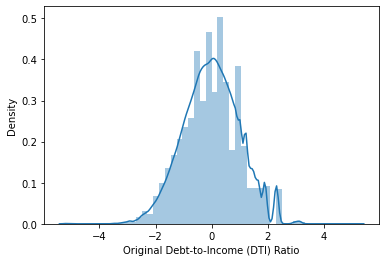

In [50]:
sns.distplot(training_dat2['Original Debt-to-Income (DTI) Ratio'])

In [51]:
# Clean Original UPB
training_dat['Original UPB'].describe()

count    3.963370e+05
mean     2.225630e+05
std      1.189133e+05
min      1.100000e+04
25%      1.310000e+05
50%      2.000000e+05
75%      2.960000e+05
max      1.129000e+06
Name: Original UPB, dtype: float64

<AxesSubplot:xlabel='Original UPB', ylabel='Density'>

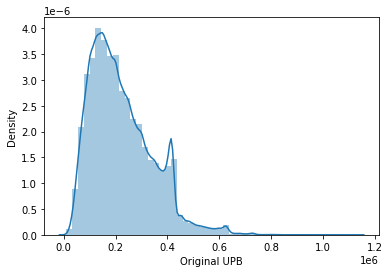

In [52]:
sns.distplot(training_dat['Original UPB'])

In [53]:
scaler_0_1_upb = QuantileTransformer(output_distribution='normal')
training_dat2['Original UPB'] = scaler_0_1_upb.fit_transform(training_dat[['Original UPB']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755,-1.252988,-0.605955
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511,-0.599937,-1.446104
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283,0.139710,-0.350817
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283,-1.252988,1.545927
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486,-1.684464,-1.550085


<AxesSubplot:xlabel='Original UPB', ylabel='Density'>

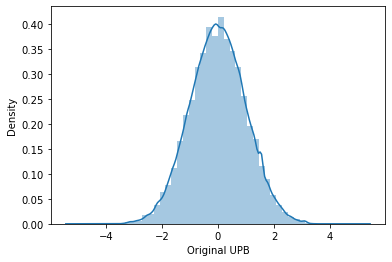

In [56]:
sns.distplot(training_dat2['Original UPB'])

In [57]:
scaler_dct['Original UPB'] = scaler_0_1_upb

In [58]:
# Clean Original Loan-to-Value (LTV)
training_dat['Original Loan-to-Value (LTV)'].describe()

count    396337.000000
mean         72.258210
std          17.734249
min           6.000000
25%          63.000000
50%          77.000000
75%          80.000000
max         999.000000
Name: Original Loan-to-Value (LTV), dtype: float64

In [59]:
tf = training_dat['Original Loan-to-Value (LTV)'] == 999
training_dat.loc[tf, 'Original Loan-to-Value (LTV)'] = np.nan

<AxesSubplot:xlabel='Original Loan-to-Value (LTV)', ylabel='Density'>

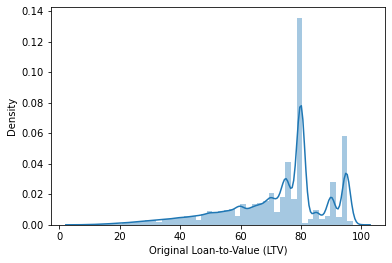

In [60]:
sns.distplot(training_dat['Original Loan-to-Value (LTV)'])

In [61]:
scaler_0_1_ltv = QuantileTransformer(output_distribution='normal')
training_dat2['Original Loan-to-Value (LTV)'] = scaler_0_1_ltv.fit_transform(training_dat[['Original Loan-to-Value (LTV)']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV)
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755,-1.252988,-0.605955,-1.588771
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511,-0.599937,-1.446104,-0.949547
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283,0.139710,-0.350817,0.421111
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283,-1.252988,1.545927,-1.057485
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486,-1.684464,-1.550085,0.095492


In [62]:
scaler_dct['Original Loan-to-Value (LTV)'] = scaler_0_1_ltv

<AxesSubplot:xlabel='Original Loan-to-Value (LTV)', ylabel='Density'>

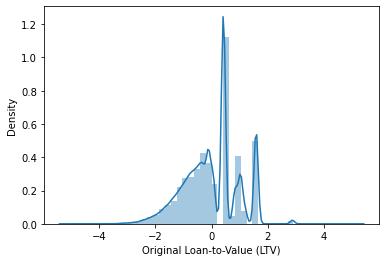

In [63]:
sns.distplot(training_dat2['Original Loan-to-Value (LTV)'])

In [64]:
# Clean Original Interest Rate
training_dat['Original Interest Rate'].describe()

count    396337.000000
mean          4.172227
std           0.607312
min           2.250000
25%           3.750000
50%           4.125000
75%           4.625000
max           6.750000
Name: Original Interest Rate, dtype: float64

<AxesSubplot:xlabel='Original Interest Rate', ylabel='Density'>

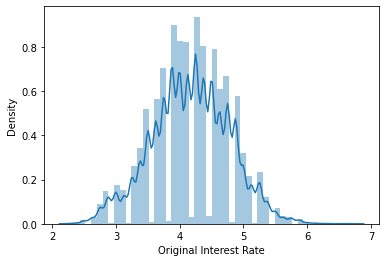

In [65]:
sns.distplot(training_dat['Original Interest Rate'])

In [66]:
scaler_0_1_intrestrate = QuantileTransformer(output_distribution='normal')
training_dat2['Original Interest Rate'] = scaler_0_1_intrestrate.fit_transform(training_dat[['Original Interest Rate']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755,-1.252988,-0.605955,-1.588771,1.161976
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511,-0.599937,-1.446104,-0.949547,1.786156
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283,0.139710,-0.350817,0.421111,1.418119
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283,-1.252988,1.545927,-1.057485,1.786156
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486,-1.684464,-1.550085,0.095492,1.418119


In [67]:
scaler_dct['Original Interest Rate'] = scaler_0_1_intrestrate

<AxesSubplot:xlabel='Original Interest Rate', ylabel='Density'>

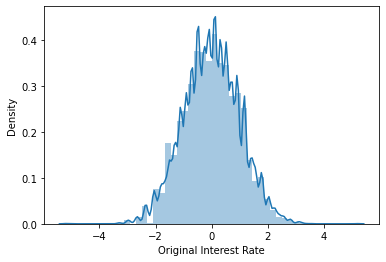

In [68]:
sns.distplot(training_dat2['Original Interest Rate'])

In [69]:
# Transform Channel
training_dat['Channel'].value_counts()

R    227989
C    125527
B     42821
Name: Channel, dtype: int64

In [70]:
dum_df = pd.get_dummies(training_dat['Channel'],prefix='Channel')
for col in list(dum_df.columns):
    training_dat2[col] = dum_df[col]
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,OccupancyStatus_P,OccupancyStatus_S,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Channel_B,Channel_C,Channel_R
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,1,0,-1.606755,-1.252988,-0.605955,-1.588771,1.161976,0,0,1
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,1,0,-0.979511,-0.599937,-1.446104,-0.949547,1.786156,0,0,1
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,1,0,0.376283,0.139710,-0.350817,0.421111,1.418119,0,0,1
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,1,0,0.376283,-1.252988,1.545927,-1.057485,1.786156,0,0,1
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,1,0,0.056486,-1.684464,-1.550085,0.095492,1.418119,0,0,1


In [71]:
training_dat['Prepayment Penalty Mortgage (PPM) Flag'].value_counts()

N    395950
Name: Prepayment Penalty Mortgage (PPM) Flag, dtype: int64

In [72]:
# Only ns, so exclude this
training_dat['Prepayment Penalty Mortgage (PPM) Flag'].unique()

array(['N', nan], dtype=object)

In [73]:
# Almost no non FRMs, so exclude
training_dat['Amortization Type (Formerly Product Type)'].value_counts()

FRM    396280
_          57
Name: Amortization Type (Formerly Product Type), dtype: int64

In [74]:
# Tranform Property Type
training_dat['Property Type'].value_counts()

SF    266922
PU    100295
CO     27220
MH      1369
CP       531
Name: Property Type, dtype: int64

In [75]:
dum_df = pd.get_dummies(training_dat['Property Type'],prefix='PropertyType')
for col in list(dum_df.columns):
    training_dat2[col] = dum_df[col]
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,Original Loan-to-Value (LTV),Original Interest Rate,Channel_B,Channel_C,Channel_R,PropertyType_CO,PropertyType_CP,PropertyType_MH,PropertyType_PU,PropertyType_SF
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,-1.588771,1.161976,0,0,1,0,0,0,0,1
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,-0.949547,1.786156,0,0,1,0,0,0,0,1
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,0.421111,1.418119,0,0,1,0,0,0,0,1
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,-1.057485,1.786156,0,0,1,0,0,0,0,1
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,0.095492,1.418119,0,0,1,0,0,0,0,1


In [76]:
# Transform Loan Purpose
training_dat['Loan Purpose'].value_counts()

P    186799
N    114318
C     95220
Name: Loan Purpose, dtype: int64

In [77]:
dum_df = pd.get_dummies(training_dat['Loan Purpose'],prefix='LoanPurpose')
for col in list(dum_df.columns):
    training_dat2[col] = dum_df[col]
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,Channel_C,Channel_R,PropertyType_CO,PropertyType_CP,PropertyType_MH,PropertyType_PU,PropertyType_SF,LoanPurpose_C,LoanPurpose_N,LoanPurpose_P
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


In [78]:
# Clean Original Loan Term
# Going to go with one hot encoding, since most loans are 30,25,20,15 etc years
training_dat['Original Loan Term'].value_counts().head(10)

360    292292
180     74346
240     18955
120      6234
300      2428
144       282
156       225
168       153
324       134
336       126
Name: Original Loan Term, dtype: int64

In [79]:
term_flags = [360,180,240,120,300]
for term in term_flags:
    col_name = 'LoanTerm_' + str(term)
    training_dat2[col_name] = 0
    tf = training_dat['Original Loan Term'] == term
    training_dat2.loc[tf, col_name] = 1
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,PropertyType_PU,PropertyType_SF,LoanPurpose_C,LoanPurpose_N,LoanPurpose_P,LoanTerm_360,LoanTerm_180,LoanTerm_240,LoanTerm_120,LoanTerm_300
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0


In [80]:
training_dat2['LoanTerm_300'].sum()

2428

In [81]:
# Will also try continuous feature
scaler_0_1_loanterm = QuantileTransformer(output_distribution='normal')
training_dat2['Original Loan Term'] = scaler_0_1_loanterm.fit_transform(training_dat[['Original Loan Term']])
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,PropertyType_SF,LoanPurpose_C,LoanPurpose_N,LoanPurpose_P,LoanTerm_360,LoanTerm_180,LoanTerm_240,LoanTerm_120,LoanTerm_300,Original Loan Term
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0.334851
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0.334851
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0.334851
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0.334851
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0.334851


In [82]:
scaler_dct['Original Loan Term'] = scaler_0_1_loanterm

In [83]:
# Transform Number of Borrowers
training_dat['Number of Borrowers'].value_counts()

2    213369
1    182968
Name: Number of Borrowers, dtype: int64

In [84]:
training_dat2['OneBorrower'] = 0
tf = training_dat['Number of Borrowers'] == 1
training_dat2.loc[tf, 'OneBorrower'] = 1

In [85]:
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,LoanPurpose_C,LoanPurpose_N,LoanPurpose_P,LoanTerm_360,LoanTerm_180,LoanTerm_240,LoanTerm_120,LoanTerm_300,Original Loan Term,OneBorrower
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0.334851,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0.334851,1
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0.334851,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0.334851,1
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0.334851,1


In [86]:
# Transform Program Indicator
training_dat['Program Indicator'].value_counts()

9    393058
H      3279
Name: Program Indicator, dtype: int64

In [87]:
training_dat2['AffordableProgramFlag'] = 0
tf = training_dat['Program Indicator'] == 'H'
training_dat2.loc[tf,'AffordableProgramFlag'] = 1
training_dat2.head()

,Loan Sequence Number,Loan Deliquency Within Year,Credit Score,First Time Homebuyer Flag,MortgageInsuranceFlag,Units_1,Units_2,Units_3,Units_4,OccupancyStatus_I,...,LoanPurpose_N,LoanPurpose_P,LoanTerm_360,LoanTerm_180,LoanTerm_240,LoanTerm_120,LoanTerm_300,Original Loan Term,OneBorrower,AffordableProgramFlag
0,F110Q1000008,False,1.315958,False,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0.334851,0,0
1,F110Q1000064,False,2.225823,False,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0.334851,1,0
2,F110Q1000072,False,0.451469,False,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0.334851,0,0
3,F110Q1000080,False,-1.733071,False,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0.334851,1,0
4,F110Q1000096,False,1.033647,False,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0.334851,1,0


In [88]:
# Exclude Property Valuation Method (2017 onwards only)
# Exclude Interest Only (I/O) Indicator nans only
training_dat['Interest Only (I/O) Indicator']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
396333   NaN
396334   NaN
396335   NaN
396336   NaN
396337   NaN
Name: Interest Only (I/O) Indicator, Length: 396337, dtype: float64

In [89]:
training_dat2.columns

Index(['Loan Sequence Number', 'Loan Deliquency Within Year', 'Credit Score',
       'First Time Homebuyer Flag', 'MortgageInsuranceFlag', 'Units_1',
       'Units_2', 'Units_3', 'Units_4', 'OccupancyStatus_I',
       'OccupancyStatus_P', 'OccupancyStatus_S',
       'Original Combined Loan-to-Value (CLTV)',
       'Original Debt-to-Income (DTI) Ratio', 'Original UPB',
       'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Channel_B',
       'Channel_C', 'Channel_R', 'PropertyType_CO', 'PropertyType_CP',
       'PropertyType_MH', 'PropertyType_PU', 'PropertyType_SF',
       'LoanPurpose_C', 'LoanPurpose_N', 'LoanPurpose_P', 'LoanTerm_360',
       'LoanTerm_180', 'LoanTerm_240', 'LoanTerm_120', 'LoanTerm_300',
       'Original Loan Term', 'OneBorrower', 'AffordableProgramFlag'],
      dtype='object')

In [90]:
len(training_dat2.columns)

36

In [91]:
tf1 = training_dat2['Loan Deliquency Within Year'] == True
tf2 = training_dat2['Loan Deliquency Within Year'] == False
training_dat2.loc[tf1, 'Loan Deliquency Within Year'] = 1
training_dat2.loc[tf2, 'Loan Deliquency Within Year'] = 0

In [92]:
tf1 = training_dat2['First Time Homebuyer Flag'] == True
tf2 = training_dat2['First Time Homebuyer Flag'] == False
training_dat2.loc[tf1, 'First Time Homebuyer Flag'] = 1
training_dat2.loc[tf2, 'First Time Homebuyer Flag'] = 0

In [93]:
training_dat2.isnull().sum()

Loan Sequence Number                           0
Loan Deliquency Within Year                    0
Credit Score                                  22
First Time Homebuyer Flag                 215276
MortgageInsuranceFlag                          0
Units_1                                        0
Units_2                                        0
Units_3                                        0
Units_4                                        0
OccupancyStatus_I                              0
OccupancyStatus_P                              0
OccupancyStatus_S                              0
Original Combined Loan-to-Value (CLTV)        11
Original Debt-to-Income (DTI) Ratio           37
Original UPB                                   0
Original Loan-to-Value (LTV)                  11
Original Interest Rate                         0
Channel_B                                      0
Channel_C                                      0
Channel_R                                      0
PropertyType_CO     

In [94]:
# Get rid of first time homebuyer flag, and then drop all nulls
del training_dat2['First Time Homebuyer Flag']
training_dat2.dropna(inplace=True)

In [95]:
len(training_dat2)

396267

In [96]:
training_dat2.to_pickle('./PROCESSED/training_dat2.pkl')

In [97]:
with open("./PROCESSED/scalers.pkl","wb") as f:
    pickle.dump(scaler_dct, f)